# 1-2 bits/cell allocations

In [2]:
# Import libraries
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import helper
from copy import deepcopy
from itertools import product

In [3]:
# Load retention time data
tdata = pd.read_csv("../data/retention/retention.min.csv.gz")

# Time point
timept = 10000

In [3]:
# Get PBA allocations
pba_allocations_bpc = {1: set(), 2: set()}

# Sweep gamma over some range
for gamma in np.arange(0, 0.0061, 0.0002):
    print("gamma =", gamma)
    lvlcands = {}
    for (lower, upper), d in tdata[tdata["timept"] == timept].groupby(["lower","upper"]):
        lvlcand = d.mean()[["timept","lower","upper","width","successes","failures","reads","sets","resets","cycles","read_bits","set_bits","reset_bits","lvl","time"]].to_dict()
        lvl, cdf = sorted(d["lvl"].values), np.linspace(0.5/len(d), 1-0.5/len(d), len(d)) # symmetric percentile CDF (https://math.stackexchange.com/questions/33488/how-to-calculate-percentile-is-it-possible-to-get-100-percentile)
        lvlcand["lvl"] = np.array(lvl)
        lvlcand["cdf"] = cdf
        try:
            # lvlcand["lower_rd"] = int(np.floor(helper.intersection(np.array([0,64]), np.array([gamma,gamma]), np.array(lvl), cdf)[0][0]))
            # lvlcand["upper_rd"] = int(np.ceil(helper.intersection(np.array([0,64]), np.array([1-gamma,1-gamma]), np.array(lvl), cdf)[0][0]))
            lvlcand["lower_rd"] = helper.intersection(np.array([0,64]), np.array([gamma,gamma]), np.array(lvl), cdf)[0][0]
            lvlcand["upper_rd"] = helper.intersection(np.array([0,64]), np.array([1-gamma,1-gamma]), np.array(lvl), cdf)[0][0]
        except IndexError:
            lvlcand["lower_rd"] = min(lvl)
            lvlcand["upper_rd"] = max(lvl)
        lvlcands[(int(lower), int(upper))] = lvlcand

    pba_allocations = []
    cur_upper = -1
    cands = [lvlcand for lvlcand in lvlcands.values() if lvlcand["lower"] == 0]
    while cands != []:
        next_cur_upper = min([cand["upper_rd"] for cand in cands])
        pba_allocations.append([(int(cand["lower"]), int(cand["upper"])) for cand in cands if cand["upper_rd"] == next_cur_upper])
        cur_upper = next_cur_upper
        cands = [lvlcand for lvlcand in lvlcands.values() if lvlcand["lower_rd"] > cur_upper]
    print(pba_allocations)
    if len(pba_allocations) >= 2:
        pba_allocations_bpc[1].update(product(*pba_allocations[:2]))
    if len(pba_allocations) >= 4:
        pba_allocations_bpc[2].update(product(*pba_allocations[:4]))
pba_allocations_bpc

gamma = 0.0
[[(0, 10)], [(34, 35)], [(52, 54)]]
gamma = 0.0002
[[(0, 10)], [(34, 35)], [(52, 54)]]
gamma = 0.0004
[[(0, 10)], [(34, 35)], [(50, 51)], [(60, 62)]]
gamma = 0.0006000000000000001
[[(0, 10)], [(34, 35)], [(50, 51)], [(60, 62)]]
gamma = 0.0008
[[(0, 10)], [(32, 33)], [(49, 50)], [(60, 62)]]
gamma = 0.001
[[(0, 10)], [(32, 33)], [(49, 50)], [(60, 62)]]
gamma = 0.0012000000000000001
[[(0, 10)], [(32, 33), (33, 34)], [(49, 50)], [(59, 60)]]
gamma = 0.0014
[[(0, 10)], [(32, 33), (33, 34)], [(49, 50)], [(59, 60)]]
gamma = 0.0016
[[(0, 10)], [(32, 33), (33, 34)], [(49, 50)], [(59, 60)]]
gamma = 0.0018000000000000002
[[(0, 10)], [(32, 33), (33, 34), (34, 35)], [(49, 50)], [(58, 60), (59, 60)]]
gamma = 0.002
[[(0, 10)], [(32, 33), (33, 34), (34, 35)], [(49, 50)], [(58, 60), (59, 60)]]
gamma = 0.0022
[[(0, 10)], [(32, 33), (33, 34), (34, 35)], [(49, 50)], [(58, 60), (59, 60)]]
gamma = 0.0024000000000000002
[[(0, 10)], [(32, 33), (33, 34), (34, 35)], [(49, 50)], [(58, 60), (59, 60)]]


{1: {((0, 9), (31, 32)),
  ((0, 10), (29, 30)),
  ((0, 10), (31, 32)),
  ((0, 10), (32, 33)),
  ((0, 10), (33, 34)),
  ((0, 10), (34, 35))},
 2: {((0, 9), (31, 32), (46, 47), (56, 57)),
  ((0, 9), (31, 32), (46, 47), (57, 58)),
  ((0, 9), (31, 32), (47, 48), (57, 58)),
  ((0, 10), (29, 30), (45, 46), (55, 56)),
  ((0, 10), (31, 32), (46, 47), (56, 57)),
  ((0, 10), (31, 32), (46, 47), (57, 58)),
  ((0, 10), (31, 32), (47, 48), (57, 58)),
  ((0, 10), (32, 33), (48, 49), (57, 58)),
  ((0, 10), (32, 33), (49, 50), (58, 59)),
  ((0, 10), (32, 33), (49, 50), (58, 60)),
  ((0, 10), (32, 33), (49, 50), (59, 60)),
  ((0, 10), (32, 33), (49, 50), (60, 62)),
  ((0, 10), (33, 34), (48, 49), (57, 58)),
  ((0, 10), (33, 34), (49, 50), (58, 59)),
  ((0, 10), (33, 34), (49, 50), (58, 60)),
  ((0, 10), (33, 34), (49, 50), (59, 60)),
  ((0, 10), (34, 35), (49, 50), (58, 60)),
  ((0, 10), (34, 35), (49, 50), (59, 60)),
  ((0, 10), (34, 35), (50, 51), (60, 62))}}

In [4]:
# Digraph
DG = nx.DiGraph()
DG.add_nodes_from(lvlcands.items())
DG.add_edges_from([(cand1, cand2) for cand1 in lvlcands for cand2 in lvlcands if lvlcands[cand2]["lower_rd"] > lvlcands[cand1]["upper_rd"]])
DG.number_of_nodes(), DG.number_of_edges()

(2013, 194132)

In [5]:
# Get all possible level allocations
allocations = []
for root in [(0,j) for j in range(64)]:
  for leaf in [(k,l) for k in range(root[1],64) for l in range(61,64)]:
    print("ROOT", root, "LEAF", leaf)
    try:
      for path in nx.all_simple_paths(DG, root, leaf):
        allocations.append(tuple(path))  
    except nx.NodeNotFound:
       pass
len(allocations)

ROOT (0, 0) LEAF (0, 61)
ROOT (0, 0) LEAF (0, 62)
ROOT (0, 0) LEAF (0, 63)
ROOT (0, 0) LEAF (1, 61)
ROOT (0, 0) LEAF (1, 62)
ROOT (0, 0) LEAF (1, 63)
ROOT (0, 0) LEAF (2, 61)
ROOT (0, 0) LEAF (2, 62)
ROOT (0, 0) LEAF (2, 63)
ROOT (0, 0) LEAF (3, 61)
ROOT (0, 0) LEAF (3, 62)
ROOT (0, 0) LEAF (3, 63)
ROOT (0, 0) LEAF (4, 61)
ROOT (0, 0) LEAF (4, 62)
ROOT (0, 0) LEAF (4, 63)
ROOT (0, 0) LEAF (5, 61)
ROOT (0, 0) LEAF (5, 62)
ROOT (0, 0) LEAF (5, 63)
ROOT (0, 0) LEAF (6, 61)
ROOT (0, 0) LEAF (6, 62)
ROOT (0, 0) LEAF (6, 63)
ROOT (0, 0) LEAF (7, 61)
ROOT (0, 0) LEAF (7, 62)
ROOT (0, 0) LEAF (7, 63)
ROOT (0, 0) LEAF (8, 61)
ROOT (0, 0) LEAF (8, 62)
ROOT (0, 0) LEAF (8, 63)
ROOT (0, 0) LEAF (9, 61)
ROOT (0, 0) LEAF (9, 62)
ROOT (0, 0) LEAF (9, 63)
ROOT (0, 0) LEAF (10, 61)
ROOT (0, 0) LEAF (10, 62)
ROOT (0, 0) LEAF (10, 63)
ROOT (0, 0) LEAF (11, 61)
ROOT (0, 0) LEAF (11, 62)
ROOT (0, 0) LEAF (11, 63)
ROOT (0, 0) LEAF (12, 61)
ROOT (0, 0) LEAF (12, 62)
ROOT (0, 0) LEAF (12, 63)
ROOT (0, 0) LEAF

72893

In [6]:
# Get all 1-2 bpc allocations
allocations_bpc = {1 : [a for a in allocations if len(a) == 2], 2 : [a for a in allocations if len(a) == 4]}
{k : len(v) for k, v in allocations_bpc.items()}

{1: 2699, 2: 13933}

In [7]:
# Plot BW-BER tradeoff in level allocations
results = []
for bpc in range(1, 3):
    for i, a in enumerate(allocations_bpc[bpc] + list(pba_allocations_bpc[bpc])):
        if i % 10 == 0:
            print(bpc, i)

        rdbounds = [0]
        for lvl1, lvl2 in zip(a[:-1], a[1:]):
            cers = []
            for i in range(64):
                if i < lvlcands[lvl1]["lvl"].min():
                    cer1 = 1
                elif i > lvlcands[lvl1]["lvl"].max():
                    cer1 = 0
                else:
                    cer1 = 1 - helper.intersection(lvlcands[lvl1]["lvl"], lvlcands[lvl1]["cdf"], np.array([i, i]), np.array([0, 1]))[1][-1]
                if i < lvlcands[lvl2]["lvl"].min():
                    cer2 = 0
                elif i > lvlcands[lvl2]["lvl"].max():
                    cer2 = 1
                else:
                    cer2 = helper.intersection(lvlcands[lvl2]["lvl"], lvlcands[lvl2]["cdf"], np.array([i, i]), np.array([0, 1]))[1][-1]
                cers.append(cer1 + cer2)
            cers = np.array(cers)
            # print("CERs:", cers)
            # print("Min indices:", np.where(cers == cers.min()))
            # print("Rounded down median min index:", int(np.median(np.where(cers == cers.min()))))
            rdbounds.append(int(np.median(np.where(cers == cers.min()))))
        rdbounds.append(64)

        times, confmat = [], []
        for i, lvl in enumerate(a):
            # Get the relevant data
            lvldata = lvlcands[lvl]

            # Compute average time to target level
            times.append(lvldata["cycles"] * 10e-9)

            # Compute the CER for level
            confvec = []
            for rdbound_low, rdbound_high in zip(rdbounds[:-1], rdbounds[1:]):
                confvec.append(len([l for l in lvldata["lvl"] if (l > rdbound_low) & (l <= rdbound_high)]))
            confmat.append(confvec)
        times, confmat = np.array(times), np.array(confmat)
        
        # Compute overall results
        bw = (48 - np.genfromtxt("../settings/dead_columns.csv", delimiter=",").size) / times.mean() * bpc

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER
        ber = (grayerr * confmat).sum() / confmat.sum()

        # CER
        cer = 1 - confmat.trace() / confmat.sum()

        # Is a PBA allocation
        is_pba = a in pba_allocations_bpc[bpc]

        # Results
        results.append([bpc, a, rdbounds, confmat, bw, ber, cer, is_pba])

# Get dataframe
data = pd.DataFrame(results, columns=["bpc", "allocation", "read_bounds", "confmat", "bw", "ber", "cer", "is_pba"]).sort_values(["ber", "bw"], ascending=[True, False])
data.to_csv("../data/allocation/allocations.csv", index=False)
data

1 0
1 10
1 20
1 30
1 40
1 50
1 60
1 70
1 80
1 90
1 100
1 110
1 120
1 130
1 140
1 150
1 160
1 170
1 180
1 190
1 200
1 210
1 220
1 230
1 240
1 250
1 260
1 270
1 280
1 290
1 300
1 310
1 320
1 330
1 340
1 350
1 360
1 370
1 380
1 390
1 400
1 410
1 420
1 430
1 440
1 450
1 460
1 470
1 480
1 490
1 500
1 510
1 520
1 530
1 540
1 550
1 560
1 570
1 580
1 590
1 600
1 610
1 620
1 630
1 640
1 650
1 660
1 670
1 680
1 690
1 700
1 710
1 720
1 730
1 740
1 750
1 760
1 770
1 780
1 790
1 800
1 810
1 820
1 830
1 840
1 850
1 860
1 870
1 880
1 890
1 900
1 910
1 920
1 930
1 940
1 950
1 960
1 970
1 980
1 990
1 1000
1 1010
1 1020
1 1030
1 1040
1 1050
1 1060
1 1070
1 1080
1 1090
1 1100
1 1110
1 1120
1 1130
1 1140
1 1150
1 1160
1 1170
1 1180
1 1190
1 1200
1 1210
1 1220
1 1230
1 1240
1 1250
1 1260
1 1270
1 1280
1 1290
1 1300
1 1310
1 1320
1 1330
1 1340
1 1350
1 1360
1 1370
1 1380
1 1390
1 1400
1 1410
1 1420
1 1430
1 1440
1 1450
1 1460
1 1470
1 1480
1 1490
1 1500
1 1510
1 1520
1 1530
1 1540
1 1550
1 1560
1 1570
1 158

,bpc,allocation,read_bounds,confmat,bw,ber,cer,is_pba
2269,1,"((0, 35), (51, 63))","[0, 40, 64]","[[1452, 0], [0, 1408]]",1.208125e+07,0.000000,0.000000,False
2187,1,"((0, 33), (51, 63))","[0, 39, 64]","[[1452, 0], [0, 1408]]",1.189908e+07,0.000000,0.000000,False
1712,1,"((0, 24), (48, 63))","[0, 33, 64]","[[1452, 0], [0, 1408]]",1.173769e+07,0.000000,0.000000,False
1460,1,"((0, 20), (48, 63))","[0, 30, 64]","[[1452, 0], [0, 1408]]",1.167258e+07,0.000000,0.000000,False
2278,1,"((0, 35), (54, 63))","[0, 42, 64]","[[1452, 0], [0, 1408]]",1.149911e+07,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...
2651,1,"((0, 49), (55, 62))","[0, 49, 64]","[[1444, 8], [8, 1400]]",4.595968e+06,0.005594,0.005594,False
1085,1,"((0, 15), (33, 62))","[0, 21, 64]","[[1443, 9], [8, 1400]]",6.766067e+06,0.005944,0.005944,False
2596,1,"((0, 46), (53, 61))","[0, 47, 64]","[[1443, 9], [8, 1400]]",5.390640e+06,0.005944,0.005944,False
1,1,"((0, 1), (35, 63))","[0, 20, 64]","[[1443, 9], [8, 1400]]",9.610446e+04,0.005944,0.005944,False


In [4]:
# Load allocations
data = pd.read_csv("../data/allocation/allocations.csv", converters={"allocation": eval, "read_bounds": eval}).drop(columns="confmat")
chosen_allocations = {0: "1.1", 1713: "1.2", 1291: "1.3", 1707: "2.1", 2011: "2.2", 13397: "2.3"}
data

,bpc,allocation,read_bounds,bw,ber,cer,is_pba
0,1,"((0, 35), (51, 63))","[0, 40, 64]",1.208125e+07,0.000000,0.000000,False
1,1,"((0, 33), (51, 63))","[0, 39, 64]",1.189908e+07,0.000000,0.000000,False
2,1,"((0, 24), (48, 63))","[0, 33, 64]",1.173769e+07,0.000000,0.000000,False
3,1,"((0, 20), (48, 63))","[0, 30, 64]",1.167258e+07,0.000000,0.000000,False
4,1,"((0, 35), (54, 63))","[0, 42, 64]",1.149911e+07,0.000000,0.000000,False
...,...,...,...,...,...,...,...
16652,1,"((0, 49), (55, 62))","[0, 49, 64]",4.595968e+06,0.005594,0.005594,False
16653,1,"((0, 15), (33, 62))","[0, 21, 64]",6.766067e+06,0.005944,0.005944,False
16654,1,"((0, 46), (53, 61))","[0, 47, 64]",5.390640e+06,0.005944,0.005944,False
16655,1,"((0, 1), (35, 63))","[0, 20, 64]",9.610446e+04,0.005944,0.005944,False


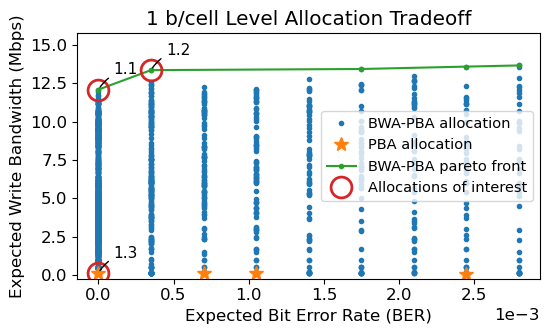

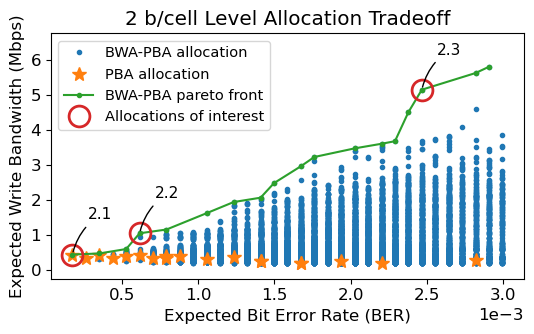

,bpc,allocation,read_bounds,bw,ber,cer,is_pba,bacc
0,1,"((0, 35), (51, 63))","[0, 40, 64]",1.208125e+07,0.000000,0.000000,False,1.000000
1713,1,"((0, 33), (48, 63))","[0, 38, 64]",1.335123e+07,0.000350,0.000350,False,0.999650
7146,1,"((0, 20), (42, 63))","[0, 28, 64]",1.342492e+07,0.001748,0.001748,False,0.998252
13346,1,"((0, 35), (48, 63))","[0, 38, 64]",1.358100e+07,0.002448,0.002448,False,0.997552
15110,1,"((0, 25), (42, 63))","[0, 29, 64]",1.365727e+07,0.002797,0.002797,False,0.997203
1291,1,"((0, 10), (34, 35))","[0, 19, 64]",1.324908e+05,0.000000,0.000000,True,1.000000
1707,2,"((0, 10), (34, 35), (50, 51), (60, 62))","[0, 19, 41, 54, 64]",4.395971e+05,0.000176,0.000352,True,0.999824
1956,2,"((0, 10), (36, 37), (50, 51), (60, 62))","[0, 19, 41, 54, 64]",4.706191e+05,0.000352,0.000705,False,0.999648
1977,2,"((0, 14), (36, 37), (50, 51), (60, 62))","[0, 22, 41, 54, 64]",5.969379e+05,0.000529,0.001057,False,0.999471
2011,2,"((0, 10), (35, 38), (50, 51), (60, 62))","[0, 17, 41, 54, 64]",1.046111e+06,0.000617,0.001233,False,0.999383


: 

In [6]:
# Pareto curve
data["bacc"] = 1 - data["ber"]
best = []
for bpc in range(1, 3):
    plt.figure(figsize=(5.5,3.5))
    plt.ylim(-0.25, 16.5/bpc - bpc*3/4)
    data_bpc = data[(data["bpc"] == bpc) & (data["ber"] <= 3e-3)] #.drop_duplicates(subset=["allocation"])
    data_bpc = data_bpc.sort_values("is_pba",ascending=False,kind="stable").drop_duplicates(subset=["ber", "bw"])

    plt.plot(data_bpc["ber"], data_bpc["bw"] / 1e6, ".", label="BWA-PBA allocation")
    plt.plot(data_bpc[data_bpc["is_pba"]]["ber"], data_bpc[data_bpc["is_pba"]]["bw"] / 1e6, "*", markersize=10, label="PBA allocation")

    costs = data_bpc[["bacc", "bw"]].values
    unique_costs = data_bpc[["bacc", "bw"]].drop_duplicates().values #
    is_pareto = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_pareto[i] = np.all(np.any(np.delete(costs,i,axis=0)<c, axis=1))
    best.append(data_bpc[is_pareto])
    plt.plot(data_bpc[is_pareto]["ber"], data_bpc[is_pareto]["bw"] / 1e6, '.-', label="BWA-PBA pareto front")
    
    pba_data_bpc = data_bpc[data_bpc["is_pba"]]
    pba_costs = pba_data_bpc[["bacc", "bw"]].values
    pba_is_pareto = np.ones(pba_data_bpc.shape[0], dtype = bool)
    for i, c in enumerate(pba_costs):
        pba_is_pareto[i] = np.all(np.any(np.delete(pba_costs,i,axis=0)<c, axis=1))
    best.append(pba_data_bpc[pba_is_pareto & (pba_data_bpc["ber"] == pba_data_bpc["ber"].min())])
    # plt.plot(pba_data_bpc[pba_is_pareto]["ber"], pba_data_bpc[pba_is_pareto]["bw"] / 1e6, '.-', label="PBA pareto front")

    evaluate = data_bpc[data_bpc.index.isin(chosen_allocations.keys())]
    plt.plot(evaluate["ber"], evaluate["bw"] / 1e6, "o", label="Allocations of interest", markerfacecolor="none", markeredgewidth=2, markersize=15)
    for i, row in evaluate.iterrows():
        plt.annotate(chosen_allocations[i], (row["ber"], row["bw"] / 1e6), (row["ber"] + 0.0001, row["bw"] / 1e6 + 1), fontsize=11, arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.2"))
    
    plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
    plt.title(f"{bpc} b/cell Level Allocation Tradeoff")
    plt.xlabel("Expected Bit Error Rate (BER)")
    plt.ylabel("Expected Write Bandwidth (Mbps)")
    plt.legend(fontsize=10.5, loc="best" if bpc == 2 else "right")
    plt.tight_layout()
    plt.savefig(f"figs/{bpc}bpc_pareto.pdf", dpi=300, bbox_inches="tight")
    plt.show()
best = pd.concat(best).drop_duplicates(subset=["allocation"])
best

bpc                              1
allocation     ((0, 35), (51, 63))
read_bounds            [0, 40, 64]
bw                 12081248.894944
ber                            0.0
cer                            0.0
is_pba                       False
bacc                           1.0
Name: 0, dtype: object


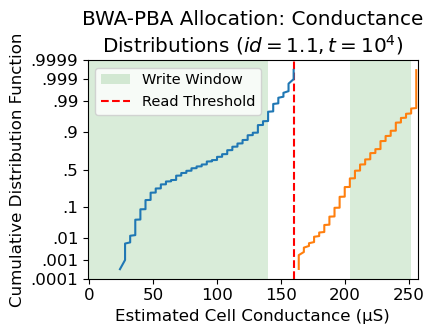

bpc                              1
allocation     ((0, 33), (48, 63))
read_bounds            [0, 38, 64]
bw                 13351225.385259
ber                        0.00035
cer                        0.00035
is_pba                       False
bacc                       0.99965
Name: 1713, dtype: object


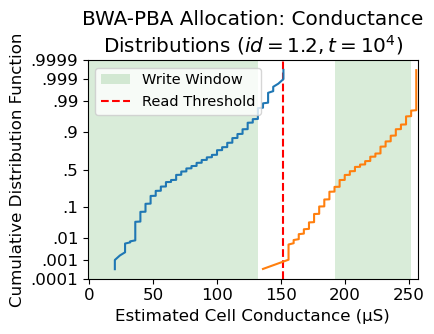

bpc                              1
allocation     ((0, 10), (34, 35))
read_bounds            [0, 19, 64]
bw                   132490.769145
ber                            0.0
cer                            0.0
is_pba                        True
bacc                           1.0
Name: 1291, dtype: object


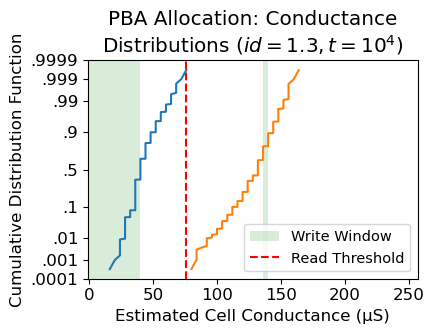

bpc                                                  2
allocation     ((0, 10), (34, 35), (50, 51), (60, 62))
read_bounds                        [0, 19, 41, 54, 64]
bw                                       439597.134827
ber                                           0.000176
cer                                           0.000352
is_pba                                            True
bacc                                          0.999824
Name: 1707, dtype: object


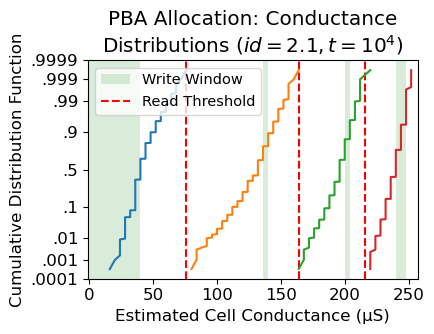

bpc                                                  2
allocation     ((0, 10), (35, 38), (50, 51), (60, 62))
read_bounds                        [0, 17, 41, 54, 64]
bw                                        1046110.8938
ber                                           0.000617
cer                                           0.001233
is_pba                                           False
bacc                                          0.999383
Name: 2011, dtype: object


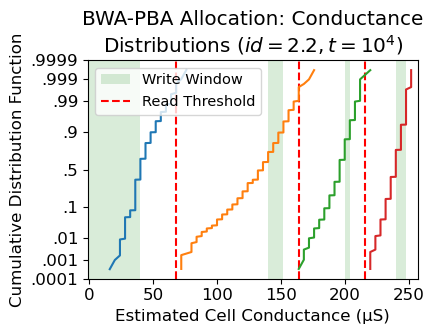

bpc                                                  2
allocation     ((0, 14), (36, 39), (50, 53), (60, 63))
read_bounds                        [0, 21, 42, 54, 64]
bw                                      5142003.667761
ber                                           0.002467
cer                                           0.004933
is_pba                                           False
bacc                                          0.997533
Name: 13397, dtype: object


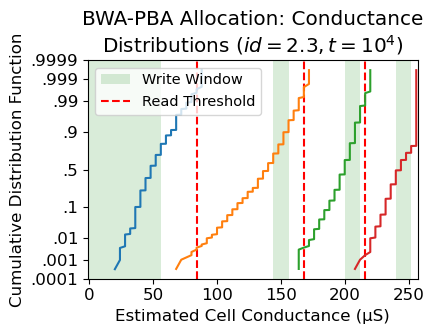

In [35]:
# Visualize chosen allocations
for i, d in best.iterrows():
    if i not in chosen_allocations:
        continue

    plt.figure(figsize=(4.5,3.5))
    plt.xlim(-1, 257)
    plt.ylim(0.0001,0.9999)
    plt.gca().set_yscale("ppf")
    plt.title(f"{'BWA-' if not d['is_pba'] else ''}PBA Allocation: Conductance\nDistributions ($id={chosen_allocations[i]}, t=10^4$)")
    plt.xlabel("Estimated Cell Conductance (µS)")
    plt.ylabel("Cumulative Distribution Function")
    print(d)
    for bounds in d["allocation"]:
        plt.gca().add_patch(patches.Rectangle((bounds[0]*4, 0.0001), bounds[1]*4-bounds[0]*4, 0.9998, linewidth=0, facecolor="green", alpha=0.15, label="Write Window" if bounds[0] == 0 else None))
    for j, bound in enumerate(d["read_bounds"]):
        if bound not in [0,64]:
            plt.axvline(bound*4, color="red", linestyle="--", label="Read Threshold" if j==1 else None)
    for j, lvl in enumerate(d["allocation"]):
        # Get the relevant data
        lvldata = tdata[(tdata["timept"] == timept) & (tdata["lower"] == lvl[0]) & (tdata["upper"] == lvl[1])]

        # Plot distributions
        plt.plot(sorted(lvldata["lvl"].values * 4), np.linspace(0.5/len(lvldata["lvl"].values), 1-0.5/len(lvldata["lvl"].values), len(lvldata["lvl"].values)))#, label=f"Level {j}")
    # if d["is_pba"]:
    #     plt.text(200, 0.5, "PBA", fontsize=12, color="red")
    plt.legend(fontsize=10.5)
    plt.tight_layout()
    plt.savefig(f"figs/alloc_{chosen_allocations[i]}.pdf")
    plt.show()

In [19]:
# Write out configs
with open("../settings/config.json") as config_tmpl_file:
    config_tmpl = json.load(config_tmpl_file)

for i, d in best.iterrows():
    with open(f"../settings/opt/{d['bpc']}bpc_{'bwa' if not d['is_pba'] else 'pba'}_{i}.json", "w") as config_outfile:
        config = deepcopy(config_tmpl)
        config["num_levels"] = len(d["allocation"])
        config["level_settings"] = config["level_settings"][:config["num_levels"]]
        config["post_read_setup_cycles"] = 2
        for lvl, ((lower_write, upper_write), read_bound) in enumerate(zip(d["allocation"], d["read_bounds"][1:])):
            config["level_settings"][lvl]["adc_lower_write_ref_lvl"] = lower_write
            config["level_settings"][lvl]["adc_upper_write_ref_lvl"] = upper_write
            config["level_settings"][lvl]["adc_upper_read_ref_lvl"] = min(read_bound, 63)
        json.dump(config, config_outfile, indent=4)